### Features combined from yorko's and Lukyanenko's public kernels

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from plotly import tools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import warnings
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import eli5
from sklearn import decomposition
import lightgbm as lgb
import xgboost as xgb

import os
from IPython.display import display_html

## Functions to create extended datasets

In [2]:
def read_matches(matches_file):   # Read json file
    
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)
    
    with open(matches_file) as fin:
        for line in tqdm_notebook(fin, total=total_matches):
            yield json.loads(line)

In [3]:
import collections

MATCH_FEATURES = [
    ('game_time', lambda m: m['game_time']),
    ('game_mode', lambda m: m['game_mode']),
    ('lobby_type', lambda m: m['lobby_type']),
    ('objectives_len', lambda m: len(m['objectives'])),
    ('chat_len', lambda m: len(m['chat'])),
]

PLAYER_FIELDS = [
    'hero_id',
    
    'kills',
    'deaths',
    'assists',
    'denies',
    
    'gold',
    'lh',
    'xp',
    'health',
    'max_health',
    'max_mana',
    'level',

    'x',
    'y',
    
    'stuns',
    'creeps_stacked',
    'camps_stacked',
    'rune_pickups',
    'firstblood_claimed',
    'teamfight_participation',
    'towers_killed',
    'roshans_killed',
    'obs_placed',
    'sen_placed',
]

def extract_features_csv(match):
    row = [
        ('match_id_hash', match['match_id_hash']),
    ]
    
    for field, f in MATCH_FEATURES:
        row.append((field, f(match)))
        
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)

        for field in PLAYER_FIELDS:
            column_name = '%s_%s' % (player_name, field)
            row.append((column_name, player[field]))
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))
            
    return collections.OrderedDict(row)
    
def extract_targets_csv(match, targets):
    return collections.OrderedDict([('match_id_hash', match['match_id_hash'])] + [
        (field, targets[field])
        for field in ['game_time', 'radiant_win', 'duration', 'time_remaining', 'next_roshan_team']
    ])

In [4]:
import json
from tqdm import tqdm_notebook

In [5]:
PATH_TO_DATA = '../../data/dota_2/'
df_new_features = []
df_new_targets = []

for match in read_matches(os.path.join(PATH_TO_DATA, 'train_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    targets = extract_targets_csv(match, match['targets'])
    
    df_new_features.append(features)
    df_new_targets.append(targets)

In [6]:
df_new_features = pd.DataFrame.from_records(df_new_features).set_index('match_id_hash')
df_new_targets = pd.DataFrame.from_records(df_new_targets).set_index('match_id_hash')

In [7]:
test_new_features = []
for match in read_matches(os.path.join(PATH_TO_DATA, 'test_matches.jsonl')):
    match_id_hash = match['match_id_hash']
    features = extract_features_csv(match)
    
    test_new_features.append(features)
test_new_features = pd.DataFrame.from_records(test_new_features).set_index('match_id_hash')

In [8]:
for c in ['kills', 'deaths', 'assists', 'denies', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level', 'x', 'y', 'stuns', 'creeps_stacked', 'camps_stacked', 'rune_pickups',
          'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'obs_placed', 'sen_placed', 'ability_level', 'max_hero_hit', 'purchase_count',
          'count_ability_use', 'damage_dealt', 'damage_received']:
    r_columns = [f'r{i}_{c}' for i in range(1, 6)]
    d_columns = [f'd{i}_{c}' for i in range(1, 6)]
    
    df_new_features['r_total_' + c] = df_new_features[r_columns].sum(1)
    df_new_features['d_total_' + c] = df_new_features[d_columns].sum(1)
    df_new_features['total_' + c + '_ratio'] = df_new_features['r_total_' + c] / df_new_features['d_total_' + c]
    
    test_new_features['r_total_' + c] = test_new_features[r_columns].sum(1)
    test_new_features['d_total_' + c] = test_new_features[d_columns].sum(1)
    test_new_features['total_' + c + '_ratio'] = test_new_features['r_total_' + c] / test_new_features['d_total_' + c]
    
    df_new_features['r_std_' + c] = df_new_features[r_columns].std(1)
    df_new_features['d_std_' + c] = df_new_features[d_columns].std(1)
    df_new_features['std_' + c + '_ratio'] = df_new_features['r_std_' + c] / df_new_features['d_std_' + c]
    
    test_new_features['r_std_' + c] = test_new_features[r_columns].std(1)
    test_new_features['d_std_' + c] = test_new_features[d_columns].std(1)
    test_new_features['std_' + c + '_ratio'] = test_new_features['r_std_' + c] / test_new_features['d_std_' + c]
    
    df_new_features['r_mean_' + c] = df_new_features[r_columns].mean(1)
    df_new_features['d_mean_' + c] = df_new_features[d_columns].mean(1)
    df_new_features['mean_' + c + '_ratio'] = df_new_features['r_mean_' + c] / df_new_features['d_mean_' + c]
    
    test_new_features['r_mean_' + c] = test_new_features[r_columns].mean(1)
    test_new_features['d_mean_' + c] = test_new_features[d_columns].mean(1)
    test_new_features['mean_' + c + '_ratio'] = test_new_features['r_mean_' + c] / test_new_features['d_mean_' + c]

In [9]:
X = df_new_features.reset_index(drop=True)
X_test = test_new_features.copy().reset_index(drop=True)

In [10]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=20000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=1000,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [11]:
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            'train_targets.csv'), 
                                   index_col='match_id_hash')

y = df_train_targets['radiant_win'].values

In [12]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

params = {'boost': 'gbdt',
          'feature_fraction': 0.05,
          'learning_rate': 0.01,
          'max_depth': -1,  
          'metric':'auc',
          'min_data_in_leaf': 50,
          'num_leaves': 32,
          'num_threads': -1,
          'verbosity': 1,
          'objective': 'binary'
         }

In [13]:
import time

Fold 0 started at Sat Nov 16 13:27:39 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.890553	valid_1's auc: 0.825952
Early stopping, best iteration is:
[1760]	training's auc: 0.930002	valid_1's auc: 0.82776
Fold 1 started at Sat Nov 16 13:28:08 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.891765	valid_1's auc: 0.813799
Early stopping, best iteration is:
[1653]	training's auc: 0.925827	valid_1's auc: 0.815356
Fold 2 started at Sat Nov 16 13:28:35 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.889588	valid_1's auc: 0.827409
[2000]	training's auc: 0.939093	valid_1's auc: 0.829622
[3000]	training's auc: 0.969546	valid_1's auc: 0.830321
Early stopping, best iteration is:
[3370]	training's auc: 0.977172	valid_1's auc: 0.830438
Fold 3 started at Sat Nov 16 13:29:22 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's auc: 0.889

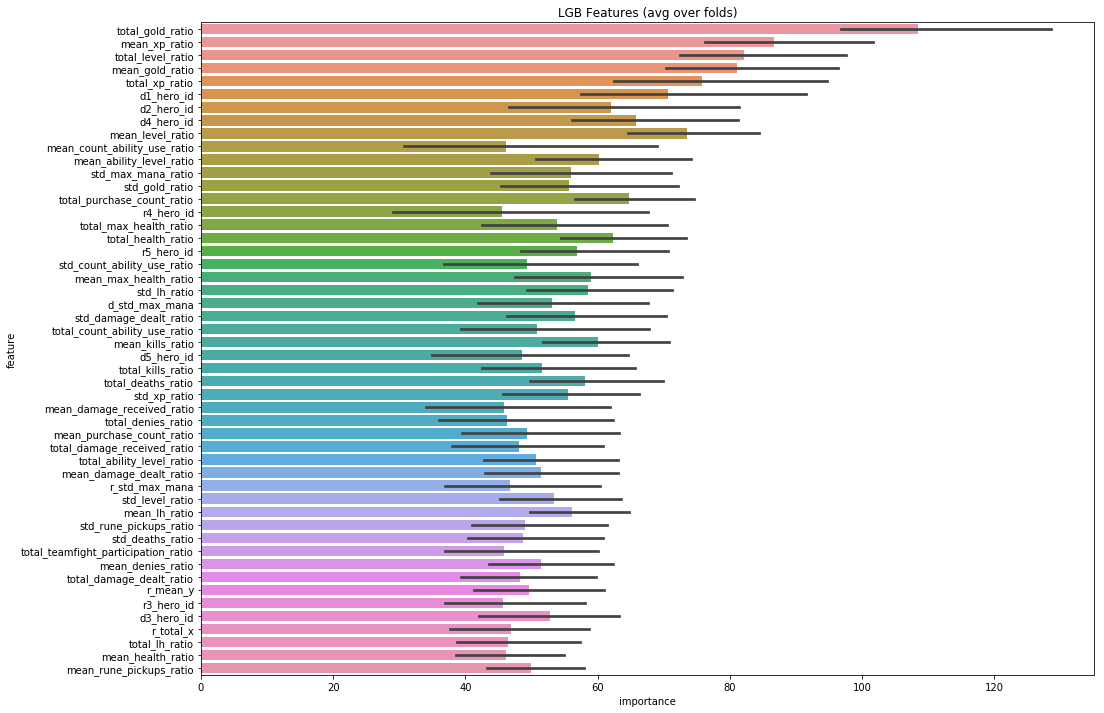

In [14]:
oof_lgb, prediction_lgb, scores = train_model(X, X_test, y, params=params, 
                                              folds=folds, model_type='lgb', plot_feature_importance=True)

In [15]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             'test_features.csv'), 
                                    index_col='match_id_hash')

In [16]:
df_submission = pd.DataFrame(
    {'radiant_win_prob': prediction_lgb}, 
    index=df_test_features.index,)

df_submission.to_csv('sumbmission_lgb1_f4.csv')

In [17]:
list(X.columns)

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r1_ability_level',
 'r1_max_hero_hit',
 'r1_purchase_count',
 'r1_count_ability_use',
 'r1_damage_dealt',
 'r1_damage_received',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r2_a

In [18]:
pd.to_pickle(X, "./train_features_4.pkl")
pd.to_pickle(X_test, "./test_features_4.pkl")

In [19]:
X.head(5)

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,mean_damage_dealt_ratio,r_total_damage_received,d_total_damage_received,total_damage_received_ratio,r_std_damage_received,d_std_damage_received,std_damage_received_ratio,r_mean_damage_received,d_mean_damage_received,mean_damage_received_ratio
0,155,22,7,1,11,11,0,0,0,0,...,0.924934,4242,1555,2.727974,375.188353,244.929582,1.531821,848.4,311.0,2.727974
1,658,4,0,3,10,15,7,2,0,7,...,1.490132,21203,24459,0.866879,2286.086350,2169.544929,1.053717,4240.6,4891.8,0.866879
2,21,23,0,0,0,101,0,0,0,0,...,1.029412,68,70,0.971429,30.410524,31.304952,0.971429,13.6,14.0,0.971429
3,576,22,7,1,4,14,1,0,3,1,...,0.729832,15246,22808,0.668450,1416.962314,989.946867,1.431352,3049.2,4561.6,0.668450
4,453,22,7,1,3,42,0,1,1,0,...,0.699205,15867,9404,1.687261,1079.992963,1121.422177,0.963057,3173.4,1880.8,1.687261


### Missing some important features from yorko's notebook